## Imports

In [22]:
# All imports
import glob
import csv
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib

## Paths

In [23]:
if not os.path.exists('charts/unlike_coordinations'):
    os.makedirs('charts/unlike_coordinations')

if not os.path.exists('charts/like_unlike_percentages'):
    os.makedirs('charts/like_unlike_percentages')

if not os.path.exists('charts/wordnet_relations'):
    os.makedirs('charts/wordnet_relations')

if not os.path.exists('charts/word2vec_analysis'):
    os.makedirs('charts/word2vec_analysis')

## Genre Codes and Names

In [24]:
genre_codes = ['acad', 'fic', 'mag', 'news', 'spok']

genre_names = {
    "acad": "Academic",
    "fic": "Fiction",
    "mag": "Magazine",
    "news": "Newspaper",
    "spok": "Spoken"
}

## Color Codes

In [25]:
genre_colors = {
    "acad": "#9B5DE5",
    "fic": "#00BBF9",
    "mag": "#38b000",
    "news": "#d90429",
    "spok": "#820263",
}

conjunction_colors = {
    "and": "#be0aff",
    "or": "#580aff",
    "but": "#0043ce",
    "nor": "#d12c19"
}

like_unlike_colors = {
    "likes": "#008bf8",
    "unlikes": "#dc0073"
}

category_colors = {
    "NP": "#ee1266",
    "VP": "#6a4c93",
    "ADJP": "#1982c4",
    "ADVP": "#0ead69",
    "PP": "#ff4b35",
    "SBAR": "#00cecb"
}

## Conjunctions and Categories Under Analysis

In [26]:
CONJUNCTIONS = ['and', 'or', 'but', 'nor']
CATEGORIES = ['NP', 'VP', 'PP', 'ADJP', 'ADVP', 'SBAR']

NOUN_CATEGORIES = ['NN', 'NNS', 'NNP', 'NNPS', 'NP', 'NX']
VERB_CATEGORIES = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'VP']
ADJ_CATEGORIES = ['JJ', 'JJR', 'JJS', 'ADJP']
ADV_CATEGORIES = ['RB', 'RBR', 'RBS', 'ADVP']
SEM_CATEGORIES = NOUN_CATEGORIES + VERB_CATEGORIES + ADJ_CATEGORIES + ADV_CATEGORIES

## General Dataframe Processing Methods

In [27]:
def process_and_filter(df, filter_cats=True, filter_conj=True):
    
    # Convert all column types to strings
    df['1st Conjunct Category'] = df['1st Conjunct Category'].astype('str')
    df['2nd Conjunct Category'] = df['2nd Conjunct Category'].astype('str')
    df['1st Conjunct Text'] = df['1st Conjunct Text'].astype('str')
    df['2nd Conjunct Text'] = df['2nd Conjunct Text'].astype('str')
    df['Conjunction'] = df['Conjunction'].astype('str')
    df['Sentence Text'] = df['Sentence Text'].astype('str')

    # df = df.loc[~(df['1st Conjunct Text'].apply(lambda t: any(char.isdigit() for char in t)))]
    # df = df.loc[~(df['2nd Conjunct Text'].apply(lambda t: any(char.isdigit() for char in t)))]

    df = df.loc[~(df['1st Conjunct Text'].str.contains("thing"))]
    df = df.loc[~(df['2nd Conjunct Text'].str.contains("thing"))]

    # Filter based on conjunctions and categories we want
    if filter_conj:
        df = df[df['Conjunction'].isin(CONJUNCTIONS)]
    if filter_cats:
        df = df[df['1st Conjunct Category'].isin(CATEGORIES)]
        df = df[df['2nd Conjunct Category'].isin(CATEGORIES)]

    return df

In [28]:
def gen_df_from_path(path):

    all_files = glob.glob(path)

    # Concatenate all CSVs in the specified path into one dataframe
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    if li == []:
        return None

    df = pd.concat(li, axis=0, ignore_index=True)
    return df

# Chart the Most Common Unlike Coordinations

This section charts the most common unlike coordinations by each individual genre AND across all genres. The top 10 most frequent unlike coordinations are displayed in each chart, in order of their relative frequency. For this analysis, the following phrasal categories are considered:

**'NP', 'VP', 'PP', 'ADJP', 'ADVP', 'SBAR'**

and the following conjunctions are considered:

**'and', 'or', 'but'**.

In [29]:
def plot_unlikes(df, genre_code=None, conjunction=None): 

    df = process_and_filter(df)

    if conjunction is not None:
        df = df.loc[df['Conjunction'] == conjunction]

    # Get unlike category combinations
    unlikes = df.loc[df['1st Conjunct Category'] != df['2nd Conjunct Category']]
    unlikes.reset_index(drop=True, inplace=True)

    unlikes['Category Combination'] = unlikes['1st Conjunct Category'] + " + " + unlikes['2nd Conjunct Category']
    categry_combinations = unlikes['Category Combination']

    # Generate top 10 most frequent unlike coordinations
    category_counter = Counter()

    for comb in categry_combinations:
        category_counter.update([comb])

    combinations = []
    popularity = []

    if genre_code is not None:
        print(genre_code)
    if conjunction is not None:
        print(conjunction)

    tot = sum(category_counter.values())
    for item in category_counter.most_common(10):
        combinations.append(item[0])
        popularity.append(item[1] / tot)
        print(item[0], '\t', item[1])

    print()
    combinations.reverse()
    popularity.reverse()

    # Configure different graph + destination settings if genre is specified or not
    if conjunction is not None:
        title = "Most Common Unlike Coordinations Containing \'" + conjunction +"\'" 
        dest_path = 'charts/unlike_coordinations/' + conjunction + '_unlikes.pdf'
        bar_color = conjunction_colors[conjunction]
    elif genre_code is None:
        title = "Most Common Unlike Coordinations Across All Genres"
        dest_path = 'charts/unlike_coordinations/total_unlikes.pdf'
        bar_color = '#202020' # a dark gray
    else:
        title = "Most Common Unlike Coordinations in " + genre_names[genre_code] + " Genre"
        dest_path = 'charts/unlike_coordinations/' + genre_code + '_unlikes.pdf'
        bar_color = genre_colors[genre_code]

    # Add percentages to bars
    fig, ax = plt.subplots()
    scale = 0.095 * popularity[-1]
    for i, v in enumerate(popularity):
        ax.text(v - scale, i - 0.15, "{:.3f}".format(round(v,3)), color='white')

    # Generate a bar graph and save as PDF
    plt.barh(combinations, popularity, color=bar_color)
    plt.title(title)
    plt.ylabel("Category Combinations")
    plt.xlabel("Relative Frequency")

    plt.savefig(dest_path, bbox_inches='tight')


### Chart the Most Common Unlike Coordinations for Each Genre

/Users/juliekallini/Desktop/Thesis/CoordinationParser/env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
acad
NP + SBAR 	 802
NP + VP 	 749
PP + NP 	 552
NP + ADJP 	 502
ADJP + VP 	 499
ADVP + PP 	 473
PP + VP 	 444
PP + ADVP 	 413
NP + PP 	 405
PP + SBAR 	 266

/Users/juliekallini/Desktop/Thesis/CoordinationParser/env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] =

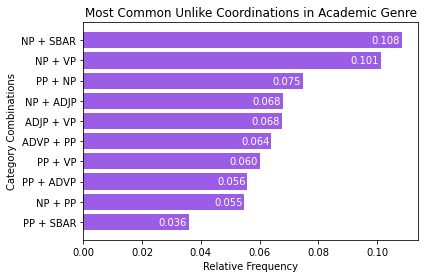

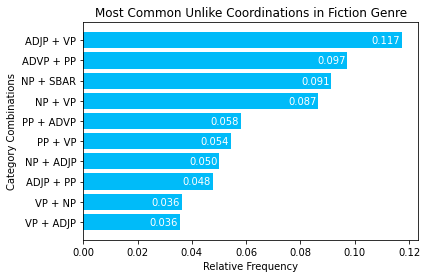

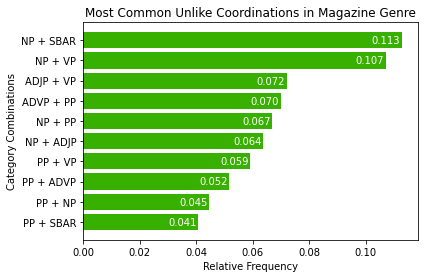

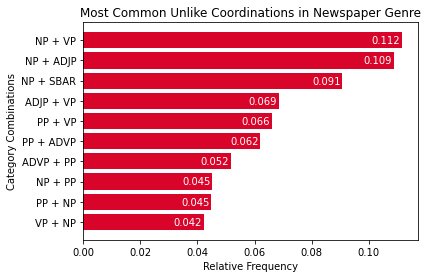

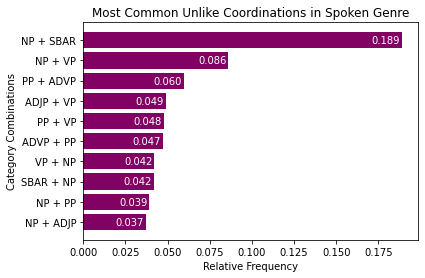

In [30]:
 for genre_code in genre_codes:

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    pathname = "w_" + genre_code + "_[0-9][0-9][0-9][0-9]"
    path = "csv/" + pathname + "/" + pathname + "_ccps.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)

    if df is not None:
        plot_unlikes(df, genre_code=genre_code)


### Chart the Most Common Unlike Coordinations By Conjunction

/Users/juliekallini/Desktop/Thesis/CoordinationParser/env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
and
NP + SBAR 	 3480
NP + VP 	 3156
ADJP + VP 	 2325
ADVP + PP 	 1810
PP + VP 	 1769
PP + ADVP 	 1741
NP + ADJP 	 1683
PP + NP 	 1397
VP + NP 	 1164
NP + PP 	 1096

/Users/juliekallini/Desktop/Thesis/CoordinationParser/env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.pa

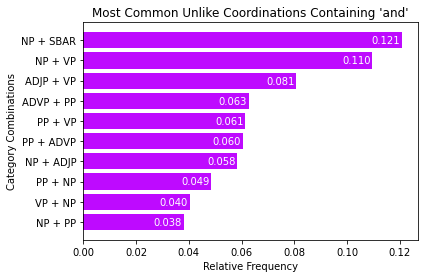

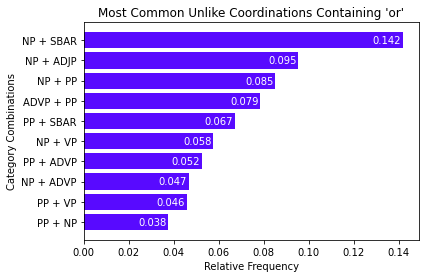

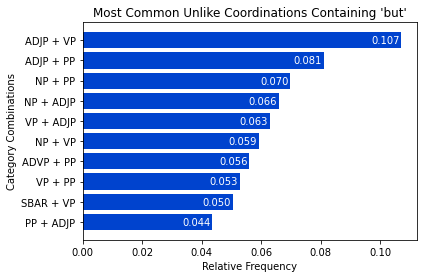

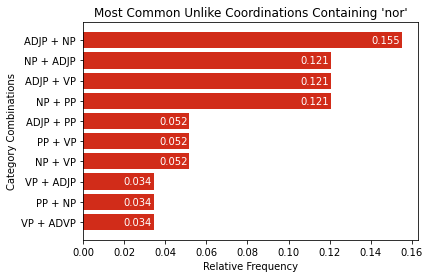

In [31]:
 for conjunction in CONJUNCTIONS:

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    df = gen_df_from_path("csv/w_*/w_*_ccps.csv")

    if df is not None:
        plot_unlikes(df, conjunction=conjunction)

### Chart the Most Common Unlike Coordinations Across All Genres

/Users/juliekallini/Desktop/Thesis/CoordinationParser/env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
NP + SBAR 	 4406
NP + VP 	 3605
ADJP + VP 	 2685
ADVP + PP 	 2379
NP + ADJP 	 2378
PP + VP 	 2098
PP + ADVP 	 2098
NP + PP 	 1734
PP + NP 	 1658
VP + NP 	 1415



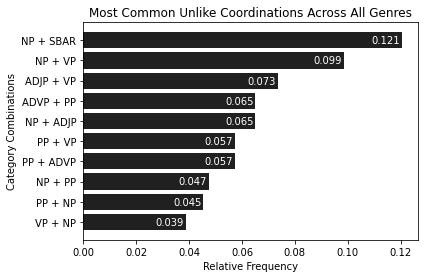

In [32]:
# Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
df = gen_df_from_path("csv/w_*/w_*_ccps.csv")

if df is not None:
    plot_unlikes(df)


### Heatmap

In [33]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["white", "black"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [34]:
df = gen_df_from_path("csv/w_*/w_*_ccps.csv")
df = process_and_filter(df)

# Get unlike category combinations
unlikes = df.loc[df['1st Conjunct Category'] != df['2nd Conjunct Category']]
unlikes.reset_index(drop=True, inplace=True)

unlikes['Category Combination'] = unlikes['1st Conjunct Category'] + " + " + unlikes['2nd Conjunct Category']
categry_combinations = unlikes['Category Combination']

# Generate top 10 most frequent unlike coordinations
category_counter = Counter()

for comb in categry_combinations:
    category_counter.update([comb])

arr=[]
for cat1 in CATEGORIES: 
    col = [] 
    for cat2 in CATEGORIES: 
        col.append(category_counter[cat1 + " + " + cat2]) 
    arr.append(col)

/Users/juliekallini/Desktop/Thesis/CoordinationParser/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


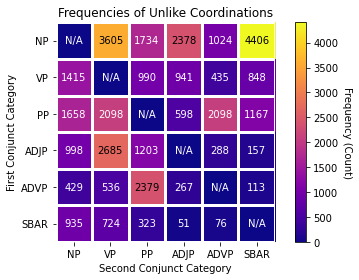

In [35]:
fig, ax = plt.subplots()

def func(x, pos):
    if x == 0:
        return "N/A"
    else:
        return str(x)

im, cbar = heatmap(np.array(arr), CATEGORIES, CATEGORIES, ax=ax, #cmap="YlGn", 
                   cmap='plasma', cbarlabel="Frequency (Count)")
texts = annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func))

# Titles
ax.set_ylabel('First Conjunct Category')
ax.set_xlabel('Second Conjunct Category')
ax.set_title("Frequencies of Unlike Coordinations")

fig.tight_layout()
plt.savefig('charts/unlike_coordinations/heatmap.pdf', bbox_inches='tight')

how 	 1349
what 	 1226
until 	 335
whatever 	 247
that 	 194
where 	 185
who 	 161
whether 	 150


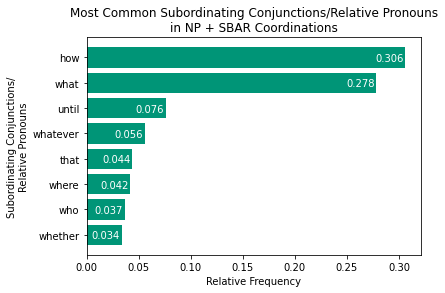

In [36]:
df = gen_df_from_path("csv/w_*/w_*_ccps.csv")

df = process_and_filter(df)

# Get unlike category combinations
unlikes = df.loc[df['1st Conjunct Category'] != df['2nd Conjunct Category']]
unlikes = unlikes.loc[df['1st Conjunct Category'] == 'NP']
unlikes = unlikes.loc[df['2nd Conjunct Category'] == 'SBAR']
unlikes.reset_index(drop=True, inplace=True)

unlikes['Subordinating Conjunction'] = unlikes['2nd Conjunct Text'].apply(lambda text: text.split()[0].lower())
sub_conjunctions = unlikes['Subordinating Conjunction']

# Generate top 10 most frequent unlike coordinations
sub_counter = Counter()

for sub in sub_conjunctions:
    sub_counter.update([sub])

# del sub_counter['who']

sub_conjs = []
popularity = []

tot = sum(sub_counter.values())
for item in sub_counter.most_common(8):
    sub_conjs.append(item[0])
    popularity.append(item[1] / tot)
    print(item[0], '\t', item[1])

sub_conjs.reverse()
popularity.reverse()

# Configure different graph + destination settings if genre is specified or not
title = "Most Common Subordinating Conjunctions/Relative Pronouns\nin NP + SBAR Coordinations"
dest_path = 'charts/unlike_coordinations/sbar_conjunctions.pdf'
bar_color = '#009577' # a dark gray

# Add percentages to bars
fig, ax = plt.subplots()
scale = 0.095 * popularity[-1]
for i, v in enumerate(popularity):
    ax.text(v - scale, i - 0.15, "{:.3f}".format(round(v,3)), color='white')

# Generate a bar graph and save as PDF
plt.barh(sub_conjs, popularity, color=bar_color)
plt.title(title)
plt.ylabel("Subordinating Conjunctions/\nRelative Pronouns")
plt.xlabel("Relative Frequency")

plt.savefig('charts/unlike_coordinations/sbar_frequencies.pdf', bbox_inches='tight')

### Most common first conjunct

2    13147
3     7619
0     5331
5     4629
1     3724
4     2109
Name: counts, dtype: int64


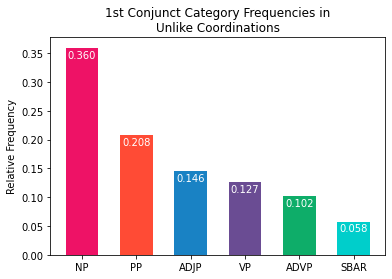

In [37]:
df = gen_df_from_path("csv/w_*/w_*_ccps.csv")

df = process_and_filter(df)

df = df.loc[df['1st Conjunct Category'] != df['2nd Conjunct Category']]
num_unlikes = len(df.index)

df = df.groupby(['1st Conjunct Category']).size().reset_index(name='counts')
df = df.sort_values(by=['counts'], ascending=False)

cats = df['1st Conjunct Category']
counts = df['counts']
freqs = []

print(counts)

for count in counts:
    freqs.append(count / num_unlikes)

x = np.arange(len(cats))  # the label locations
width = 0.6  # the width of the bars

colors = []
for cat in cats:
    colors.append(category_colors[cat])

fig, ax = plt.subplots()
rects1 = ax.bar(x, freqs, width, color=colors)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Relative Frequency')
ax.set_title('1st Conjunct Category Frequencies in\nUnlike Coordinations')
ax.set_xticks(x)
ax.set_xticklabels(cats)

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

plt.savefig('charts/unlike_coordinations/first_conjuncts.pdf', bbox_inches='tight')

### Most common second conjunct

5    9648
4    6691
3    6629
2    5435
0    4235
1    3921
Name: counts, dtype: int64


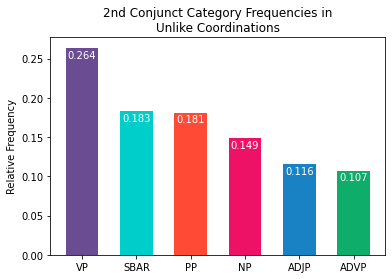

In [38]:
df = gen_df_from_path("csv/w_*/w_*_ccps.csv")

df = process_and_filter(df)

df = df.loc[df['1st Conjunct Category'] != df['2nd Conjunct Category']]
num_unlikes = len(df.index)

df = df.groupby(['2nd Conjunct Category']).size().reset_index(name='counts')
df = df.sort_values(by=['counts'], ascending=False)

cats = df['2nd Conjunct Category']
counts = df['counts']
freqs = []

print(counts)

for count in counts:
    freqs.append(count / num_unlikes)

x = np.arange(len(cats))  # the label locations
width = 0.6  # the width of the bars

colors = []
for cat in cats:
    colors.append(category_colors[cat])

fig, ax = plt.subplots()
rects1 = ax.bar(x, freqs, width, color=colors)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Relative Frequency')
ax.set_title('2nd Conjunct Category Frequencies in\nUnlike Coordinations')
ax.set_xticks(x)
ax.set_xticklabels(cats)

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

plt.savefig('charts/unlike_coordinations/second_conjuncts.pdf', bbox_inches='tight')

# Chart the Like vs. Unlike Ratio

This section charts the ratio of like coordinations versus unlike coordinations, by genre AND by conjunction. For this analysis, the following phrasal categories are considered:

**'NP', 'VP', 'PP', 'ADJP', 'ADVP', 'SBAR'**

and the following conjunctions are considered:

**'and', 'or', 'but'**.

In [39]:
def get_likes_freqs(df):

    # Get unlike category combinations
    likes = df.loc[(df['1st Conjunct Category']) == (df['2nd Conjunct Category'])]
    likes.reset_index(drop=True, inplace=True)

    # Get unlike category combinations
    unlikes = df.loc[(df['1st Conjunct Category']) != (df['2nd Conjunct Category'])]
    unlikes.reset_index(drop=True, inplace=True)

    # Get counts
    count_likes = len(likes.index)
    count_unlikes = len(unlikes.index)

    print('likes:', str(count_likes))
    print('unlikes:', str(count_unlikes))

    tot = len(df.index)

    return (count_likes / tot, count_unlikes / tot)

### By Genre

acad
likes: 163285
unlikes: 7392

fic
likes: 155001
unlikes: 6457

mag
likes: 159483
unlikes: 7732

news
likes: 159387
unlikes: 7013

spok
likes: 115990
unlikes: 7965



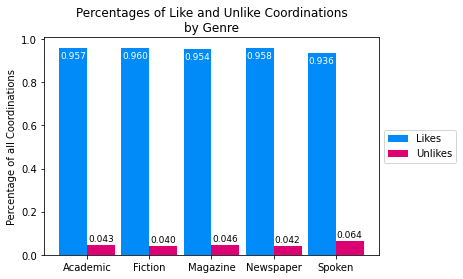

In [40]:
labels = []
like_freqs = []
unlike_freqs = []

for genre_code in genre_codes:
    print(genre_code)

    labels.append(genre_names[genre_code])

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    pathname = "w_" + genre_code + "_[0-9][0-9][0-9][0-9]"
    path = "csv/" + pathname + "/" + pathname + "_ccps.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)

    if df is None:
        continue

    df = process_and_filter(df)
    like_freq, unlike_freq = get_likes_freqs(df)

    like_freqs.append(like_freq)
    unlike_freqs.append(unlike_freq)

    print()

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, like_freqs, width, label='Likes', color=like_unlike_colors["likes"])
rects2 = ax.bar(x + width/2, unlike_freqs, width, label='Unlikes', color=like_unlike_colors["unlikes"])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of all Coordinations')
ax.set_title('Percentages of Like and Unlike Coordinations\nby Genre')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                fontsize=9,
                textcoords="offset points",
                ha='center', va='bottom', color='white')

for rect in rects2:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 2),
                fontsize=9,
                textcoords="offset points",
                ha='center', va='bottom')

plt.savefig('charts/like_unlike_percentages/percent_likes_genre.pdf', bbox_inches='tight')

### By Conjunction

and
likes: 676036
unlikes: 28994

or
likes: 70362
unlikes: 6160

but
likes: 17719
unlikes: 1648

nor
likes: 1096
unlikes: 58



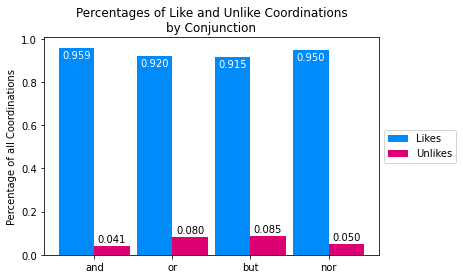

In [41]:
labels = []
like_freqs = []
unlike_freqs = []

for conjunction in CONJUNCTIONS:
    print(conjunction)

    labels.append(conjunction)

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    path = "csv/*/*_ccps.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)

    if df is None:
        continue

    df = process_and_filter(df)
    df = df.loc[df['Conjunction'] == conjunction]
    like_freq, unlike_freq = get_likes_freqs(df)
    
    like_freqs.append(like_freq)
    unlike_freqs.append(unlike_freq)

    print()

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, like_freqs, width, label='Likes', color=like_unlike_colors["likes"])
rects2 = ax.bar(x + width/2, unlike_freqs, width, label='Unlikes', color=like_unlike_colors["unlikes"])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of all Coordinations')
ax.set_title('Percentages of Like and Unlike Coordinations\nby Conjunction')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

for rect in rects2:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 2),
                textcoords="offset points",
                ha='center', va='bottom')

plt.savefig('charts/like_unlike_percentages/percent_likes_conjunction.pdf', bbox_inches='tight')

## PTB

In [42]:
def plot_unlikes_ptb(df, conjunction=None): 

    df = process_and_filter(df)

    if conjunction is not None:
        df = df.loc[df['Conjunction'] == conjunction]

    # Get unlike category combinations
    unlikes = df.loc[df['1st Conjunct Category'] != df['2nd Conjunct Category']]
    unlikes.reset_index(drop=True, inplace=True)

    unlikes['Category Combination'] = unlikes['1st Conjunct Category'] + " + " + unlikes['2nd Conjunct Category']
    categry_combinations = unlikes['Category Combination']

    # Generate top 10 most frequent unlike coordinations
    category_counter = Counter()

    for comb in categry_combinations:
        category_counter.update([comb])

    combinations = []
    popularity = []

    if conjunction is not None:
        print(conjunction)

    tot = sum(category_counter.values())
    for item in category_counter.most_common(10):
        combinations.append(item[0])
        popularity.append(item[1] / tot)
        print(item[0], '\t', item[1])

    print()
    combinations.reverse()
    popularity.reverse()

    # Configure different graph + destination settings if genre is specified or not
    if conjunction is not None:
        title = "Most Common Unlike Coordinations in PTB Containing \'" + conjunction +"\'" 
        dest_path = 'charts/unlike_coordinations/PTB_' + conjunction + '_unlikes.pdf'
        bar_color = conjunction_colors[conjunction]
    else:
        title = "Most Common Unlike Coordinations in PTB"
        dest_path = 'charts/unlike_coordinations/PTB_total_unlikes.pdf'
        bar_color = '#00819E' # a blue

    # Add percentages to bars
    fig, ax = plt.subplots()
    scale = 0.095 * popularity[-1]
    for i, v in enumerate(popularity):
        ax.text(v - scale, i - 0.15, "{:.3f}".format(round(v,3)), color='white')

    # Generate a bar graph and save as PDF
    plt.barh(combinations, popularity, color=bar_color)
    plt.title(title)
    plt.ylabel("Category Combinations")
    plt.xlabel("Relative Frequency")

    plt.savefig(dest_path, bbox_inches='tight')


/Users/juliekallini/Desktop/Thesis/CoordinationParser/env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
ADVP + PP 	 34
PP + ADVP 	 33
NP + ADJP 	 29
ADJP + NP 	 20
NP + ADVP 	 18
ADJP + VP 	 18
ADJP + PP 	 17
PP + SBAR 	 17
NP + SBAR 	 15
VP + ADJP 	 15



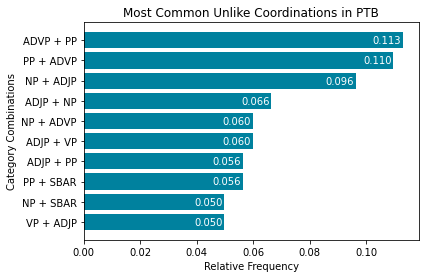

In [43]:
df = gen_df_from_path("csv/PTB/PTB_ccps.csv")

if df is not None:
    plot_unlikes_ptb(df)

2    80
3    73
0    65
1    50
5    21
4    12
Name: counts, dtype: int64


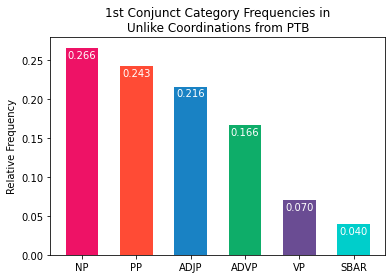

In [44]:
df = gen_df_from_path("csv/PTB/PTB_ccps.csv")

df = process_and_filter(df)

df = df.loc[df['1st Conjunct Category'] != df['2nd Conjunct Category']]
num_unlikes = len(df.index)

df = df.groupby(['1st Conjunct Category']).size().reset_index(name='counts')
df = df.sort_values(by=['counts'], ascending=False)

cats = df['1st Conjunct Category']
counts = df['counts']
freqs = []

print(counts)

for count in counts:
    freqs.append(count / num_unlikes)

x = np.arange(len(cats))  # the label locations
width = 0.6  # the width of the bars

colors = []
for cat in cats:
    colors.append(category_colors[cat])

fig, ax = plt.subplots()
rects1 = ax.bar(x, freqs, width, color=colors)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Relative Frequency')
ax.set_title('1st Conjunct Category Frequencies in\nUnlike Coordinations from PTB')
ax.set_xticks(x)
ax.set_xticklabels(cats)

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

plt.savefig('charts/unlike_coordinations/PTB_first_conjuncts.pdf', bbox_inches='tight')

3    72
1    63
0    55
2    42
4    35
5    34
Name: counts, dtype: int64


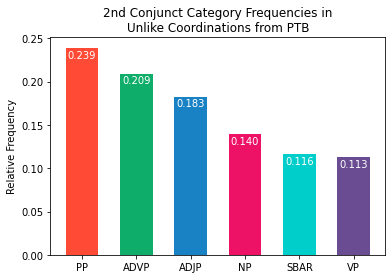

In [45]:
df = gen_df_from_path("csv/PTB/PTB_ccps.csv")

df = process_and_filter(df)

df = df.loc[df['1st Conjunct Category'] != df['2nd Conjunct Category']]
num_unlikes = len(df.index)

df = df.groupby(['2nd Conjunct Category']).size().reset_index(name='counts')
df = df.sort_values(by=['counts'], ascending=False)

cats = df['2nd Conjunct Category']
counts = df['counts']
freqs = []

print(counts)

for count in counts:
    freqs.append(count / num_unlikes)

x = np.arange(len(cats))  # the label locations
width = 0.6  # the width of the bars

colors = []
for cat in cats:
    colors.append(category_colors[cat])

fig, ax = plt.subplots()
rects1 = ax.bar(x, freqs, width, color=colors)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Relative Frequency')
ax.set_title('2nd Conjunct Category Frequencies in\nUnlike Coordinations from PTB')
ax.set_xticks(x)
ax.set_xticklabels(cats)

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

plt.savefig('charts/unlike_coordinations/PTB_second_conjuncts.pdf', bbox_inches='tight')

In [46]:
df = gen_df_from_path("csv/PTB/PTB_ccps.csv")
df = process_and_filter(df)

# Get unlike category combinations
unlikes = df.loc[df['1st Conjunct Category'] != df['2nd Conjunct Category']]
unlikes.reset_index(drop=True, inplace=True)

unlikes['Category Combination'] = unlikes['1st Conjunct Category'] + " + " + unlikes['2nd Conjunct Category']
categry_combinations = unlikes['Category Combination']

# Generate top 10 most frequent unlike coordinations
category_counter = Counter()

for comb in categry_combinations:
    category_counter.update([comb])

arr=[]
for cat1 in CATEGORIES: 
    col = [] 
    for cat2 in CATEGORIES: 
        col.append(category_counter[cat1 + " + " + cat2]) 
    arr.append(col)

/Users/juliekallini/Desktop/Thesis/CoordinationParser/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


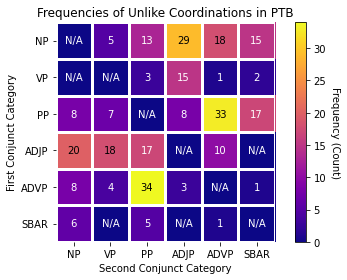

In [47]:
fig, ax = plt.subplots()

def func(x, pos):
    if x == 0:
        return "N/A"
    else:
        return str(x)

im, cbar = heatmap(np.array(arr), CATEGORIES, CATEGORIES, ax=ax, #cmap="YlGn", 
                   cmap='plasma', cbarlabel="Frequency (Count)")
texts = annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func))

# Titles
ax.set_ylabel('First Conjunct Category')
ax.set_xlabel('Second Conjunct Category')
ax.set_title("Frequencies of Unlike Coordinations in PTB")

fig.tight_layout()
plt.savefig('charts/unlike_coordinations/PTB_heatmap.pdf', bbox_inches='tight')

and
likes: 9429
unlikes: 197

or
likes: 1902
unlikes: 61

but
likes: 698
unlikes: 43

nor
likes: 38
unlikes: 0



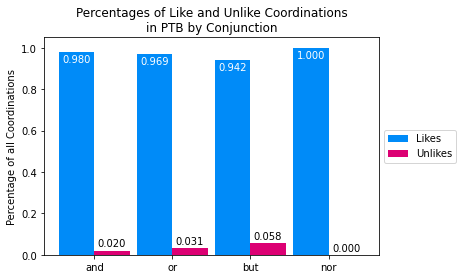

In [48]:
labels = []
like_freqs = []
unlike_freqs = []

for conjunction in CONJUNCTIONS:
    print(conjunction)

    labels.append(conjunction)

    path = "csv/PTB/PTB_ccps.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)

    if df is None:
        continue

    df = process_and_filter(df)
    df = df.loc[df['Conjunction'] == conjunction]
    like_freq, unlike_freq = get_likes_freqs(df)
    
    like_freqs.append(like_freq)
    unlike_freqs.append(unlike_freq)

    print()

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, like_freqs, width, label='Likes', color=like_unlike_colors["likes"])
rects2 = ax.bar(x + width/2, unlike_freqs, width, label='Unlikes', color=like_unlike_colors["unlikes"])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of all Coordinations')
ax.set_title('Percentages of Like and Unlike Coordinations\nin PTB by Conjunction')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

for rect in rects2:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 2),
                textcoords="offset points",
                ha='center', va='bottom')

plt.savefig('charts/like_unlike_percentages/PTB_percent_likes_conjunction.pdf', bbox_inches='tight')

# WordNet Relational Analysis

This section provides an analysis of WordNet relations between the syntactic heads of conjuncts. The definition of 'relatedness' is loose; for example, if there exists a sense of the first conjunct that is a hypernym of some sense of the second conjunct, we count this coordination as containing a hypernymy relationship.

The following nominal categories are included:

**'NN', 'NNS', 'NNP', 'NNPS', 'NP', 'NX'**

The following verbal categories are included:

**'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'VP'**

The following adjectival categories are included:

**'JJ', 'JJR', 'JJS', 'ADJP'**

The following conjunctions are considered:

**'and', 'or', 'but', 'nor'**

A hypernymy or entailment relationship must ***not*** apply in both directions. We gather all coordinations containing some WordNet relation, and compare the ratios of the direction in which the relation proceeds, i.e., if the first conjunct is a hypernym/entails the second or vice versa. We conduct this analysis both by genre and by conjunction.

## Synonyms

In [49]:
def get_synonyms_freqs(df):
    # Get synonyms
    syns = df.loc[(df['Synonyms?'] == True)]
    syns.reset_index(drop=True, inplace=True)

    # Get counts
    count_syns = len(syns.index)
    tot = len(df.index)

    print('syns:', count_syns)
    print('not syns:', tot - count_syns)

    return count_syns / tot

### By genre

acad
syns: 11514
not syns: 219786
fic
syns: 7752
not syns: 189172
mag
syns: 8002
not syns: 200524
news
syns: 8654
not syns: 190781
spok
syns: 11796
not syns: 124968


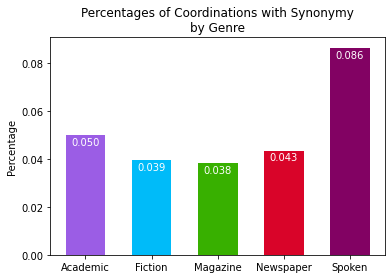

In [50]:
labels = []
syns_freqs = []

for genre_code in genre_codes:
    print(genre_code)
    
    labels.append(genre_names[genre_code])

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    pathname = "w_" + genre_code + "_[0-9][0-9][0-9][0-9]"
    path = "csv/" + pathname + "/" + pathname + "_syns.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)

    if df is None:
        continue

    df = process_and_filter(df, filter_cats=False)
    syns_freqs.append(get_synonyms_freqs(df))

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, syns_freqs, width, color=genre_colors.values())

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Percentages of Coordinations with Synonymy\nby Genre')
ax.set_xticks(x)
ax.set_xticklabels(labels)

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

plt.savefig('charts/wordnet_relations/percent_synonymy_genre.pdf', bbox_inches='tight')

### By conjunction

and
syns: 40981
not syns: 823297
or
syns: 5587
not syns: 82762
but
syns: 1111
not syns: 17557
nor
syns: 39
not syns: 1615


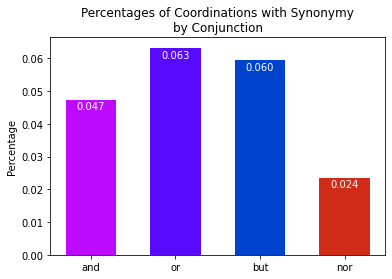

In [51]:
labels = []
syns_freqs = []

for conjunction in CONJUNCTIONS:
    print(conjunction)
    
    labels.append(conjunction)

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    path = "csv/*/*_syns.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)
    df = df.loc[df['Conjunction'] == conjunction]

    if df is None:
        continue

    df = process_and_filter(df, filter_cats=False)
    syns_freqs.append(get_synonyms_freqs(df))

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, syns_freqs, width, color=conjunction_colors.values())

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Percentages of Coordinations with Synonymy\nby Conjunction')
ax.set_xticks(x)
ax.set_xticklabels(labels)

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

plt.savefig('charts/wordnet_relations/percent_synonymy_conjunction.pdf', bbox_inches='tight')

### By category

Nominal
syns: 20604
not syns: 507905
Verbal
syns: 20154
not syns: 320833
Adjectival
syns: 3553
not syns: 85349
Adverbial
syns: 3407
not syns: 11144


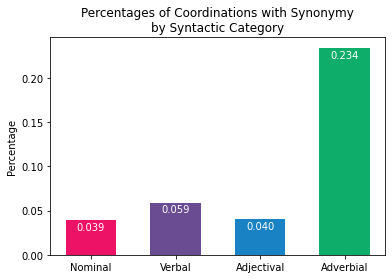

In [52]:
labels = []
syns_freqs = []


print('Nominal')
labels.append('Nominal')

# Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
path = "csv/*/*_syns.csv"

# Concatenate all CSVs for the specified genre into one dataframe
df = gen_df_from_path(path)
df = df.loc[df['1st Conjunct Category'].isin(NOUN_CATEGORIES)]
df = df.loc[df['2nd Conjunct Category'].isin(NOUN_CATEGORIES)]

df = process_and_filter(df, filter_cats=False)
syns_freqs.append(get_synonyms_freqs(df))


print('Verbal')
labels.append('Verbal')

# Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
path = "csv/*/*_syns.csv"

# Concatenate all CSVs for the specified genre into one dataframe
df = gen_df_from_path(path)
df = df.loc[df['1st Conjunct Category'].isin(VERB_CATEGORIES)]
df = df.loc[df['2nd Conjunct Category'].isin(VERB_CATEGORIES)]

df = process_and_filter(df, filter_cats=False)
syns_freqs.append(get_synonyms_freqs(df))

print('Adjectival')
labels.append('Adjectival')


# Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
path = "csv/*/*_syns.csv"

# Concatenate all CSVs for the specified genre into one dataframe
df = gen_df_from_path(path)
df = df.loc[df['1st Conjunct Category'].isin(ADJ_CATEGORIES)]
df = df.loc[df['2nd Conjunct Category'].isin(ADJ_CATEGORIES)]

df = process_and_filter(df, filter_cats=False)
syns_freqs.append(get_synonyms_freqs(df))

print('Adverbial')
labels.append('Adverbial')


# Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
path = "csv/*/*_syns.csv"

# Concatenate all CSVs for the specified genre into one dataframe
df = gen_df_from_path(path)
df = df.loc[df['1st Conjunct Category'].isin(ADV_CATEGORIES)]
df = df.loc[df['2nd Conjunct Category'].isin(ADV_CATEGORIES)]

df = process_and_filter(df, filter_cats=False)
syns_freqs.append(get_synonyms_freqs(df))

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, syns_freqs, width, color=category_colors.values())

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Percentages of Coordinations with Synonymy\nby Syntactic Category')
ax.set_xticks(x)
ax.set_xticklabels(labels)

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

plt.savefig('charts/wordnet_relations/percent_synonymy_category.pdf', bbox_inches='tight')

## Antonymy

In [53]:
def get_antonyms_freqs(df):
    # Get synonyms
    ants = df.loc[(df['Antonyms?'] == True)]
    ants.reset_index(drop=True, inplace=True)

    # Get counts
    count_ants = len(ants.index)
    tot = len(df.index)

    print('ants:', count_ants)
    print('not ants:', tot - count_ants)

    return count_ants / tot

### By genre

acad
ants: 3925
not ants: 29671
fic
ants: 1516
not ants: 19428
mag
ants: 1925
not ants: 19881
news
ants: 1513
not ants: 14265
spok
ants: 1176
not ants: 10153


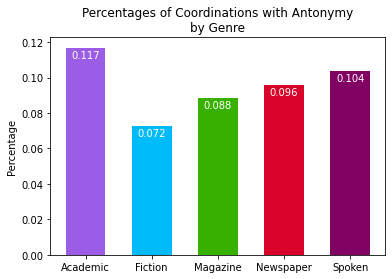

In [54]:
labels = []
ants_freqs = []

for genre_code in genre_codes:
    print(genre_code)

    labels.append(genre_names[genre_code])

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    pathname = "w_" + genre_code + "_[0-9][0-9][0-9][0-9]"
    path = "csv/" + pathname + "/" + pathname + "_ants.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)

    if df is None:
        continue

    df = process_and_filter(df, filter_cats=False)
    ants_freqs.append(get_antonyms_freqs(df))

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, ants_freqs, width, color=genre_colors.values())

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Percentages of Coordinations with Antonymy\nby Genre')
ax.set_xticks(x)
ax.set_xticklabels(labels)

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

plt.savefig('charts/wordnet_relations/percent_antonymy_genre.pdf', bbox_inches='tight')

### By conjunction

and
ants: 6960
not ants: 79821
or
ants: 2907
not ants: 9202
but
ants: 112
not ants: 4124
nor
ants: 76
not ants: 251


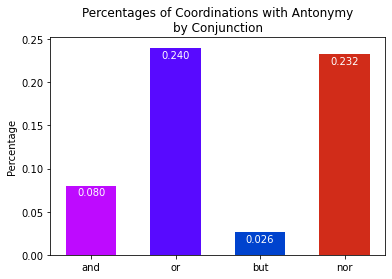

In [55]:
labels = []
ants_freqs = []

for conjunction in CONJUNCTIONS:
    print(conjunction)
    
    labels.append(conjunction)

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    path = "csv/*/*_ants.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)
    df = df.loc[df['Conjunction'] == conjunction]

    if df is None:
        continue

    df = process_and_filter(df, filter_cats=False)
    ants_freqs.append(get_antonyms_freqs(df))

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, ants_freqs, width, color=conjunction_colors.values())

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Percentages of Coordinations with Antonymy\nby Conjunction')
ax.set_xticks(x)
ax.set_xticklabels(labels)

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

plt.savefig('charts/wordnet_relations/percent_antonymy_conjunction.pdf', bbox_inches='tight')

## Hypernymy

In [56]:
def get_hypernymy_freqs(df):
    df = df.loc[(df['1st Conjunct Hypernym?'] == True) | (df['2nd Conjunct Hypernym?'] == True)]
    df = df.loc[(df['1st Conjunct Hypernym?']) != (df['2nd Conjunct Hypernym?'])]

    # Get 1st conjunct hypernymy
    hyps1 = df.loc[(df['1st Conjunct Hypernym?'] == True)]
    hyps1.reset_index(drop=True, inplace=True)

    # Get 2nd conjunct hypernymy
    hyps2 = df.loc[(df['2nd Conjunct Hypernym?'] == True)]
    hyps2.reset_index(drop=True, inplace=True)

    # Get counts
    count_hyps1 = len(hyps1.index)
    count_hyps2 = len(hyps2.index)
    tot = len(df.index)

    print('hyps1:', count_hyps1)
    print('hyps2:', count_hyps2)
    
    return (count_hyps1 / tot, count_hyps2 / tot)

### By Genre

acad
hyps1: 8423
hyps2: 9025

fic
hyps1: 7637
hyps2: 8890

mag
hyps1: 7490
hyps2: 8856

news
hyps1: 7893
hyps2: 8779

spok
hyps1: 5921
hyps2: 7134



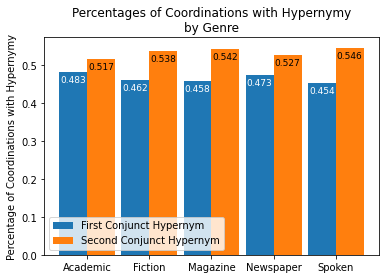

In [57]:
labels = []
hyps1_freqs = []
hyps2_freqs = []

for genre_code in genre_codes:
    print(genre_code)

    labels.append(genre_names[genre_code])

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    pathname = "w_" + genre_code + "_[0-9][0-9][0-9][0-9]"
    path = "csv/" + pathname + "/" + pathname + "_hyp.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)

    if df is None:
        continue

    df = process_and_filter(df, filter_cats=False)
    
    hyps1_freq, hyps2_freq = get_hypernymy_freqs(df)
    hyps1_freqs.append(hyps1_freq)
    hyps2_freqs.append(hyps2_freq)

    print()

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, hyps1_freqs, width, label='First Conjunct Hypernym')
rects2 = ax.bar(x + width/2, hyps2_freqs, width, label='Second Conjunct Hypernym')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of Coordinations with Hypernymy')
ax.set_title('Percentages of Coordinations with Hypernymy\nby Genre')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(0, 0.1))

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                fontsize=9,
                textcoords="offset points",
                ha='center', va='bottom', color='white')

for rect in rects2:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                fontsize=9,
                textcoords="offset points",
                ha='center', va='bottom')

plt.savefig('charts/wordnet_relations/percent_hypernymy_genre.pdf', bbox_inches='tight')

### By Conjunction

and
hyps1: 32823
hyps2: 37815

or
hyps1: 3408
hyps2: 3775

but
hyps1: 1096
hyps2: 1054

nor
hyps1: 37
hyps2: 40



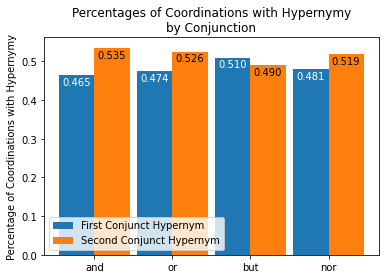

In [58]:
labels = []
hyps1_freqs = []
hyps2_freqs = []

for conjunction in CONJUNCTIONS:
    print(conjunction)

    labels.append(conjunction)

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    path = "csv/*/*_hyp.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)
    df = df.loc[df['Conjunction'] == conjunction]

    if df is None:
        continue

    df = process_and_filter(df, filter_cats=False)
    
    hyps1_freq, hyps2_freq = get_hypernymy_freqs(df)
    hyps1_freqs.append(hyps1_freq)
    hyps2_freqs.append(hyps2_freq)

    print()

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, hyps1_freqs, width, label='First Conjunct Hypernym')
rects2 = ax.bar(x + width/2, hyps2_freqs, width, label='Second Conjunct Hypernym')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of Coordinations with Hypernymy')
ax.set_title('Percentages of Coordinations with Hypernymy\nby Conjunction')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(0, 0.1))

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

for rect in rects2:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom')

plt.savefig('charts/wordnet_relations/percent_hypernymy_conjunction.pdf', bbox_inches='tight')

### By category

Nominal
hyps1: 12662
hyps2: 16123

Verbal
hyps1: 24702
hyps2: 26561



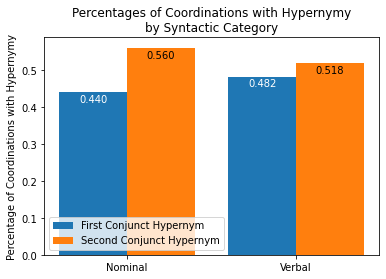

In [59]:
labels = []
hyps1_freqs = []
hyps2_freqs = []


print('Nominal')
labels.append('Nominal')

# Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
path = "csv/*/*_hyp.csv"
df = gen_df_from_path(path)
df = df.loc[df['1st Conjunct Category'].isin(NOUN_CATEGORIES)]
df = df.loc[df['2nd Conjunct Category'].isin(NOUN_CATEGORIES)]

df = process_and_filter(df, filter_cats=False)
    
hyps1_freq, hyps2_freq = get_hypernymy_freqs(df)
hyps1_freqs.append(hyps1_freq)
hyps2_freqs.append(hyps2_freq)

print()


print('Verbal')
labels.append('Verbal')

# Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
path = "csv/*/*_hyp.csv"
df = gen_df_from_path(path)
df = df.loc[df['1st Conjunct Category'].isin(VERB_CATEGORIES)]
df = df.loc[df['2nd Conjunct Category'].isin(VERB_CATEGORIES)]

df = process_and_filter(df, filter_cats=False)
    
hyps1_freq, hyps2_freq = get_hypernymy_freqs(df)
hyps1_freqs.append(hyps1_freq)
hyps2_freqs.append(hyps2_freq)

print()


x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, hyps1_freqs, width, label='First Conjunct Hypernym')
rects2 = ax.bar(x + width/2, hyps2_freqs, width, label='Second Conjunct Hypernym')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of Coordinations with Hypernymy')
ax.set_title('Percentages of Coordinations with Hypernymy\nby Syntactic Category')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(0, 0.1))

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

for rect in rects2:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom')

plt.savefig('charts/wordnet_relations/percent_hypernymy_category.pdf', bbox_inches='tight')

## Co-hyponymy

In [60]:
def get_co_hyponymy_freqs(df):
    # Get co-hyponymy
    hyps = df.loc[(df['Co-hyponyms?'] == True)]
    hyps.reset_index(drop=True, inplace=True)

    # Get counts
    count_hyps = len(hyps.index)
    tot = len(df.index)

    print('cohyps:', count_hyps)
    print('cohyps:', tot - count_hyps)

    return count_hyps / tot

### By genre

acad
cohyps: 27604
cohyps: 170100
fic
cohyps: 32267
cohyps: 143713
mag
cohyps: 28610
cohyps: 158110
news
cohyps: 26755
cohyps: 156902
spok
cohyps: 26037
cohyps: 99398


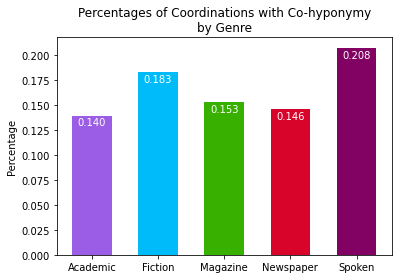

In [61]:
labels = []
hyps_freqs = []

for genre_code in genre_codes:
    print(genre_code)

    labels.append(genre_names[genre_code])

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    pathname = "w_" + genre_code + "_[0-9][0-9][0-9][0-9]"
    path = "csv/" + pathname + "/" + pathname + "_hyp.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)

    if df is None:
        continue

    df = process_and_filter(df, filter_cats=False)
    hyps_freqs.append(get_co_hyponymy_freqs(df))

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, hyps_freqs, width, color=genre_colors.values())

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Percentages of Coordinations with Co-hyponymy\nby Genre')
ax.set_xticks(x)
ax.set_xticklabels(labels)

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

plt.savefig('charts/wordnet_relations/percent_cohyponymy_genre.pdf', bbox_inches='tight')

### By conjunction

and
cohyps: 124907
cohyps: 652590
or
cohyps: 13283
cohyps: 62957
but
cohyps: 2920
cohyps: 11512
nor
cohyps: 163
cohyps: 1164


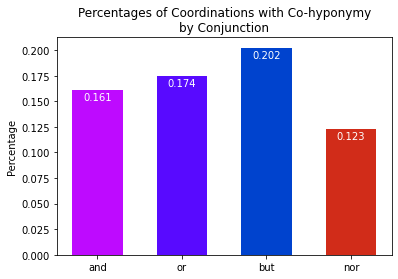

In [62]:
labels = []
hyps_freqs = []

for conjunction in CONJUNCTIONS:
    
    print(conjunction)
    
    labels.append(conjunction)

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    path = "csv/*/*_hyp.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)
    df = df.loc[df['Conjunction'] == conjunction]

    if df is None:
        continue

    df = process_and_filter(df, filter_cats=False)
    hyps_freqs.append(get_co_hyponymy_freqs(df))

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, hyps_freqs, width, color=conjunction_colors.values())

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Percentages of Coordinations with Co-hyponymy\nby Conjunction')
ax.set_xticks(x)
ax.set_xticklabels(labels)

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

plt.savefig('charts/wordnet_relations/percent_cohyponymy_conjunction.pdf', bbox_inches='tight')

### By category

Nominal
cohyps: 58786
cohyps: 469723
Verbal
cohyps: 82487
cohyps: 258500


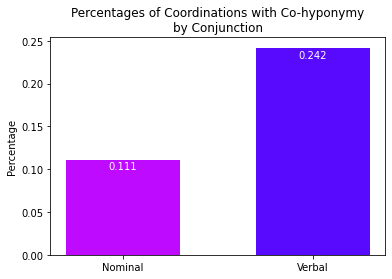

In [63]:
labels = []
hyps_freqs = []

print('Nominal')
labels.append('Nominal')

# Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
path = "csv/*/*_hyp.csv"

df = gen_df_from_path(path)
df = df.loc[df['1st Conjunct Category'].isin(NOUN_CATEGORIES)]
df = df.loc[df['2nd Conjunct Category'].isin(NOUN_CATEGORIES)]

df = process_and_filter(df, filter_cats=False)
hyps_freqs.append(get_co_hyponymy_freqs(df))


print('Verbal')
labels.append('Verbal')

# Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
path = "csv/*/*_hyp.csv"

df = gen_df_from_path(path)
df = df.loc[df['1st Conjunct Category'].isin(VERB_CATEGORIES)]
df = df.loc[df['2nd Conjunct Category'].isin(VERB_CATEGORIES)]

df = process_and_filter(df, filter_cats=False)
hyps_freqs.append(get_co_hyponymy_freqs(df))


x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, hyps_freqs, width, color=conjunction_colors.values())

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Percentages of Coordinations with Co-hyponymy\nby Conjunction')
ax.set_xticks(x)
ax.set_xticklabels(labels)

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

plt.savefig('charts/wordnet_relations/percent_cohyponymy_category.pdf', bbox_inches='tight')

## Entailment

In [64]:
def get_entailment_freqs(df):
    df = df.loc[(df['1st Conjunct Entails 2nd?'] == True) | (df['2nd Conjunct Entails 1st?'] == True)]
    df = df.loc[(df['1st Conjunct Entails 2nd?']) != (df['2nd Conjunct Entails 1st?'])]

    # Get 1st conjunct entailment
    entl1 = df.loc[(df['1st Conjunct Entails 2nd?'] == True)]
    entl1.reset_index(drop=True, inplace=True)

    # Get 2nd conjunct entailment
    entl2 = df.loc[(df['2nd Conjunct Entails 1st?'] == True)]
    entl2.reset_index(drop=True, inplace=True)

    # Get counts
    count_entl1 = len(entl1.index)
    count_entl2 = len(entl2.index)
    tot = len(df.index)

    print('entl1:', count_entl1)
    print('entl2:', count_entl2)
    
    return (count_entl1 / tot, count_entl2 / tot)

### By Genre

acad
entl1: 123
entl2: 158

fic
entl1: 384
entl2: 569

mag
entl1: 265
entl2: 333

news
entl1: 379
entl2: 400

spok
entl1: 396
entl2: 576



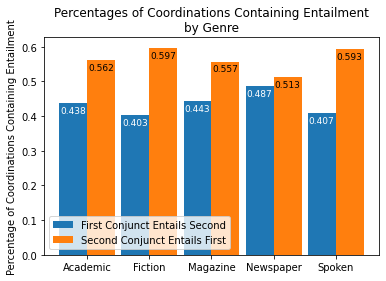

In [65]:
labels = []
entl1_freqs = []
entl2_freqs = []

for genre_code in genre_codes:
    print(genre_code)

    labels.append(genre_names[genre_code])

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    pathname = "w_" + genre_code + "_[0-9][0-9][0-9][0-9]"
    path = "csv/" + pathname + "/" + pathname + "_entl.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)

    if df is None:
        continue

    df = process_and_filter(df, filter_cats=False)
    
    entl1_freq, entl2_freq = get_entailment_freqs(df)
    entl1_freqs.append(entl1_freq)
    entl2_freqs.append(entl2_freq)

    print()

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, entl1_freqs, width, label='First Conjunct Entails Second')
rects2 = ax.bar(x + width/2, entl2_freqs, width, label='Second Conjunct Entails First')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of Coordinations Containing Entailment')
ax.set_title('Percentages of Coordinations Containing Entailment\nby Genre')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(0, 0.1))

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                fontsize=9,
                textcoords="offset points",
                ha='center', va='bottom', color='white')

for rect in rects2:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                fontsize=9,
                textcoords="offset points",
                ha='center', va='bottom')

plt.savefig('charts/wordnet_relations/percent_entailment_genre.pdf', bbox_inches='tight')

### By Conjunction

and
entl1: 1410
entl2: 1893

or
entl1: 97
entl2: 88

but
entl1: 40
entl2: 55



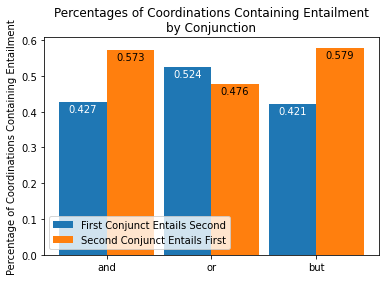

In [66]:
labels = []
entl1_freqs = []
entl2_freqs = []

for conjunction in ['and', 'or', 'but']:
    print(conjunction)

    labels.append(conjunction)

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    path = "csv/*/*_entl.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)

    if df is None:
        continue

    df = process_and_filter(df, filter_cats=False)
    df = df.loc[df['Conjunction'] == conjunction]

    entl1_freq, entl2_freq = get_entailment_freqs(df)
    entl1_freqs.append(entl1_freq)
    entl2_freqs.append(entl2_freq)

    print()

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, entl1_freqs, width, label='First Conjunct Entails Second')
rects2 = ax.bar(x + width/2, entl2_freqs, width, label='Second Conjunct Entails First')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of Coordinations Containing Entailment')
ax.set_title('Percentages of Coordinations Containing Entailment\nby Conjunction')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(0, 0.1))

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom', color='white')

for rect in rects2:
    height = rect.get_height()
    ax.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='bottom')

plt.savefig('charts/wordnet_relations/percent_entailment_conjunction.pdf', bbox_inches='tight')

## Cosine Similarity

In [67]:
def likes_df(df):
    nouns = df[(df['1st Conjunct Category'].isin(NOUN_CATEGORIES)) & (
        df['2nd Conjunct Category'].isin(NOUN_CATEGORIES))]

    verbs = df[(df['1st Conjunct Category'].isin(VERB_CATEGORIES)) & (
        df['2nd Conjunct Category'].isin(VERB_CATEGORIES))]

    adjps = df[(df['1st Conjunct Category'].isin(ADJ_CATEGORIES)) & (
        df['2nd Conjunct Category'].isin(ADJ_CATEGORIES))]

    advps = df[(df['1st Conjunct Category'].isin(ADV_CATEGORIES)) & (
        df['2nd Conjunct Category'].isin(ADV_CATEGORIES))]

    likes = pd.concat([nouns, verbs, adjps, advps],
                      axis=0, ignore_index=True)

    return likes


def unlikes_df(df):
    CATS = ['NP', 'VP', 'ADJP', 'ADVP']
    df = df[df['1st Conjunct Category'].isin(CATS)]
    df = df[df['2nd Conjunct Category'].isin(CATS)]

    # Get unlike category combinations
    unlikes = df.loc[df['1st Conjunct Category']
                     != df['2nd Conjunct Category']]

    return unlikes

In [68]:
# Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
path = "csv/*/*_sim.csv"

# Concatenate all CSVs for the specified genre into one dataframe
df = gen_df_from_path(path)

df = process_and_filter(df, filter_cats=False)

# Get like category combinations
likes = likes_df(df)

# Get unlike category combinations
unlikes = unlikes_df(df)

print('likes mean:', str(likes['Similarity'].mean()))
print('likes std:', str(likes['Similarity'].std()))
print('likes cnt:', str(len(likes.index)))
print()
print('unlikes mean:', str(unlikes['Similarity'].mean()))
print('unlikes std:', str(unlikes['Similarity'].std()))
print('unlikes cnt:', str(len(unlikes.index)))

likes mean: 0.2782655664507363
likes std: 0.21433497815282046
likes cnt: 972949

unlikes mean: 0.15789994662482174
unlikes std: 0.14794061454294505
unlikes cnt: 15001


acad
likes mean: 0.28191206787011985
likes std: 0.22013924502466517
likes cnt: 231300
unlikes mean: 0.16513122210092632
unlikes std: 0.1684634581055001
unlikes cnt: 2800

fic
likes mean: 0.25598360912244666
likes std: 0.18821701138776833
likes cnt: 196924
unlikes mean: 0.14206422803364396
unlikes std: 0.12537347317527908
unlikes cnt: 2906

mag
likes mean: 0.26922355758208516
likes std: 0.20191330455983766
likes cnt: 208526
unlikes mean: 0.15545461140159297
unlikes std: 0.14463984813521702
unlikes cnt: 3168

news
likes mean: 0.2757265168237131
likes std: 0.21266935053357602
likes cnt: 199435
unlikes mean: 0.1713392187452677
unlikes std: 0.1620570820087372
unlikes cnt: 3240

spok
likes mean: 0.3218865909425691
likes std: 0.2511801220340694
likes cnt: 136764
unlikes mean: 0.1556938848655508
unlikes std: 0.13398360750882404
unlikes cnt: 2887



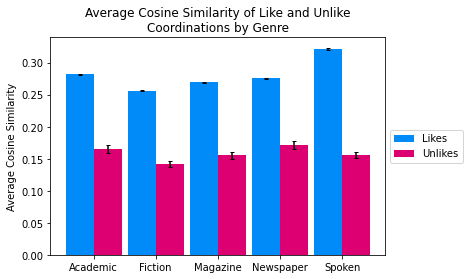

In [69]:
labels = []
like_freqs = []
like_vars = []
unlike_freqs = []
unlike_vars = []

for genre_code in genre_codes:

    print(genre_code)

    labels.append(genre_names[genre_code])

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    pathname = "w_" + genre_code + "_[0-9][0-9][0-9][0-9]"
    path = "csv/" + pathname + "/" + pathname + "_sim.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)

    if df is None:
        continue

    df = process_and_filter(df, filter_cats=False)

    # Get like category combinations
    likes = likes_df(df)

    # Get unlike category combinations
    unlikes = unlikes_df(df)

    print('likes mean:', str(likes['Similarity'].mean()))
    print('likes std:', str(likes['Similarity'].std()))
    print('likes cnt:', str(len(likes.index)))

    print('unlikes mean:', str(unlikes['Similarity'].mean()))
    print('unlikes std:', str(unlikes['Similarity'].std()))
    print('unlikes cnt:', str(len(unlikes.index)))
    print()

    like_freqs.append(likes['Similarity'].mean())
    like_vars.append(likes['Similarity'].sem())
    unlike_freqs.append(unlikes['Similarity'].mean())
    unlike_vars.append(unlikes['Similarity'].sem())

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

like_sems = []
for v in like_vars:
    like_sems.append(v * 2)

unlike_sems = []
for v in unlike_vars:
    unlike_sems.append(v * 2)

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, like_freqs, width, label='Likes', capsize=2, color=like_unlike_colors["likes"], yerr=like_sems)
rects2 = ax.bar(x + width/2, unlike_freqs, width, label='Unlikes', capsize=2, color=like_unlike_colors["unlikes"], yerr=unlike_sems)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Cosine Similarity')
ax.set_title('Average Cosine Similarity of Like and Unlike\nCoordinations by Genre')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for rect in rects1:
    height = rect.get_height()
    # ax.annotate('{:.3f}'.format(height),
    #             xy=(rect.get_x() + rect.get_width() / 2, height),
    #             xytext=(0, -12),
    #             fontsize=9,
    #             textcoords="offset points",
    #             ha='center', va='bottom', color='white')

for rect in rects2:
    height = rect.get_height()
    # ax.annotate('{:.3f}'.format(height),
    #             xy=(rect.get_x() + rect.get_width() / 2, height),
    #             xytext=(0, -12),
    #             fontsize=9,
    #             textcoords="offset points",
    #             ha='center', va='bottom', color='white')

plt.savefig('charts/word2vec_analysis/cossim_genre.pdf', bbox_inches='tight')

and
likes mean: 0.27497540072994553
likes std: 0.2113650508926771
likes cnt: 864278
unlikes mean: 0.1538011502890667
unlikes std: 0.1455353937319356
unlikes cnt: 12142

or
likes mean: 0.3155570658630975
likes std: 0.24023311257852345
likes cnt: 88349
unlikes mean: 0.1866669350056211
unlikes std: 0.16474862159946133
unlikes cnt: 2071

but
likes mean: 0.253280497811089
likes std: 0.20251688500951978
likes cnt: 18668
unlikes mean: 0.1494529788298836
unlikes std: 0.13209112723815866
unlikes cnt: 754

nor
likes mean: 0.28651461546830354
likes std: 0.20806033760292256
likes cnt: 1654
unlikes mean: 0.1253667847828611
unlikes std: 0.10827562695448417
unlikes cnt: 34



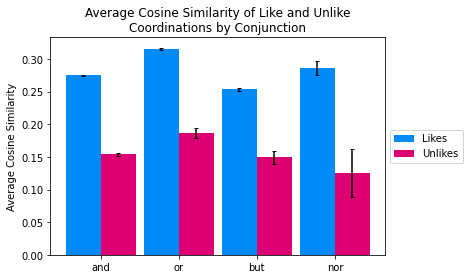

In [70]:
labels = []
like_freqs = []
like_vars = []
unlike_freqs = []
unlike_vars = []

for conjunction in CONJUNCTIONS:
    print(conjunction)
    
    labels.append(conjunction)

    # Assumes path has form: csv/w_[genre]_[year]/w_[genre]_[year].csv
    path = "csv/*/*_sim.csv"

    # Concatenate all CSVs for the specified genre into one dataframe
    df = gen_df_from_path(path)

    if df is None:
        continue
    
    df = process_and_filter(df, filter_cats=False)
    df = df.loc[df['Conjunction'] == conjunction]

    # Get like category combinations
    likes = likes_df(df)

    # Get unlike category combinations
    unlikes = unlikes_df(df)

    print('likes mean:', str(likes['Similarity'].mean()))
    print('likes std:', str(likes['Similarity'].std()))
    print('likes cnt:', str(len(likes.index)))
    
    print('unlikes mean:', str(unlikes['Similarity'].mean()))
    print('unlikes std:', str(unlikes['Similarity'].std()))
    print('unlikes cnt:', str(len(unlikes.index)))
    print()

    like_freqs.append(likes['Similarity'].mean())
    like_vars.append(likes['Similarity'].sem())
    unlike_freqs.append(unlikes['Similarity'].mean())
    unlike_vars.append(unlikes['Similarity'].sem())

like_sems = []
for v in like_vars:
    like_sems.append(v * 2)

unlike_sems = []
for v in unlike_vars:
    unlike_sems.append(v * 2)

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, like_freqs, width, label='Likes', capsize=2, color=like_unlike_colors["likes"], yerr=like_sems)
rects2 = ax.bar(x + width/2, unlike_freqs, width, label='Unlikes', capsize=2, color=like_unlike_colors["unlikes"], yerr=unlike_sems)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Cosine Similarity')
ax.set_title('Average Cosine Similarity of Like and Unlike\nCoordinations by Conjunction')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for rect in rects1:
    height = rect.get_height()
    # ax.annotate('{:.3f}'.format(height),
    #             xy=(rect.get_x() + rect.get_width() / 2, height),
    #             xytext=(0, -12),
    #             textcoords="offset points",
    #             ha='center', va='bottom', color='white')

for rect in rects2:
    height = rect.get_height()
    # ax.annotate('{:.3f}'.format(height),
    #             xy=(rect.get_x() + rect.get_width() / 2, height),
    #             xytext=(0, -12),
    #             textcoords="offset points",
    #             ha='center', va='bottom', color='white')

plt.savefig('charts/word2vec_analysis/cossim_conjunction.pdf', bbox_inches='tight')